# Clip the `hyras` dataset for one catchment and year

This is a long text explainging what this notebook does in detail

## Parameters


This notebook is supposed to be run with `papermill`. These are the parameters, that can be changed from outside the notebook, using papermill.
Values in here reflect default values and are not meant to be changed directly.

In [1]:
# parameters for this catchment
catchment_id = 'DE110010'
variable = 'hurs'
local_cache = None

# some settings to control the processing
WITH_PAPERMILL = False
MANUAL_RUN = False

# general settings
target_bucket = 'camels_output_data'
notebook_bucket = 'camels_notebooks'
catchments_path = './merit_hydro_catchments.gpkg'
base_url = "https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de"

## Preamble

This part import necessary packages and derives some needed parameters from the supplied parameters.

In [2]:
from typing import Optional, Union
import tempfile
from datetime import datetime as dt
from tqdm import tqdm
from pathlib import Path
from io import BytesIO, IOBase

from dotenv import load_dotenv
import httpx
import duckdb
import xarray as xr
import geopandas as gpd
from geocube.api.core import make_geocube

load_dotenv()

True

In [3]:
# handle the local cache path
if local_cache is None:
    local_cache = Path.cwd() / catchment_id
else:
    local_cache = Path(local_cache)

if not local_cache.exists():
    local_cache.mkdir(parents=True, exist_ok=True)

This notebook is intended to be run by `papermill` to ensure, that it ran automatically with transparent setting of parameters.
As we expect some runs to fail on specific catchments, it is also possible to inspect these notebooks and run them by hand. To do so, you
need to set the `MANUAL_RUN` flag to `True`, otherwise, the next cell will raise an exception and create an error file.

If you need to postprocess a specific version of this notebook, you have to indicate the changes you did in the next cell, by supplying a description, which will be stored along with the processed files.

In [4]:
# this is the error handler, to abort the execution of the notebook

error_msg = f"""The execution of the clip_catchment_from_hyras.ipynb has been cancelled on {dt.utcnow()} UTC.
The reason is, that the notebook was not executed with papermill, and/or the parameter WITH_PAPERMILL was not set to `True` by papermill.
This is necessary to ensure, that all HYRAS files where processed in exactly the same way.
By this we state clear data and processing provenance for the CAMELS-DE dataset.

In case you tried to debug this notebook, or fix specificities about some catchments, you can set the parameter MANUAL_RUN to `True` 
and execute the notebook again. In that case it is abosulely necessary to update the notebook to reflect the changes you made.
In addition, you should explain all changes in the notebook itself, and upload it to the other notebooks.

DEBUG
-----
catchment_id: {catchment_id}
variable: {variable}
catchments_path: {catchments_path}
local_cache: {local_cache}

HYRAS
-----
base_url: {base_url}
target_bucket: {target_bucket}
notebook_bucket: {notebook_bucket}
"""
if not WITH_PAPERMILL and not MANUAL_RUN:
    # raise the error, to let papermill handle it
    raise RuntimeError(error_msg)

RuntimeError: The execution of the clip_catchment_from_hyras.ipynb has been cancelled on 2024-01-11 14:37:07.449934 UTC.
The reason is, that the notebook was not executed with papermill, and/or the parameter WITH_PAPERMILL was not set to `True` by papermill.
This is necessary to ensure, that all HYRAS files where processed in exactly the same way.
By this we state clear data and processing provenance for the CAMELS-DE dataset.

In case you tried to debug this notebook, or fix specificities about some catchments, you can set the parameter MANUAL_RUN to `True` 
and execute the notebook again. In that case it is abosulely necessary to update the notebook to reflect the changes you made.
In addition, you should explain all changes in the notebook itself, and upload it to the other notebooks.

DEBUG
-----
catchment_id: DE110010
variable: hurs
catchments_path: ./merit_hydro_catchments.gpkg
local_cache: /home/mirko/Dropbox/python/clipper/src/DE110010

HYRAS
-----
base_url: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de
target_bucket: camels_output_data
notebook_bucket: camels_notebooks


Define the necessary functions to download the hyras dataset and to download the catchments, if not supplied locally.
Outside of this notebook, you can use the `db.DuckProcessor`, which can do all of that and be configured directly, or by environment variables.
These cells re-define the needed functionality to make the notebook self-contained. You do not need `db.DuckProcessor` to run it.

In [5]:
VAR_MAP = {
    'pr': 'preciptation',
    'hurs': 'humidity',
    'rsds': 'radiation_global',
    'tas': 'air_temperature_mean',
    'tasmax': 'air_temperature_max',
    'tasmin': 'air_temperature_min'
}

def download_hyras(variable: str, year: int, path: Optional[IOBase] = None) -> Union[IOBase, str]:
    # build the filename 
    filename = f"{variable}_hyras_{1 if variable in ('pr') else 5}_{year}_v{3 if variable == 'rsds' else 5}-0_de.nc"
    # build the specific url
    url = f"{base_url}/{VAR_MAP[variable]}/{filename}"

    # download
    response = httpx.get(url)
    if response.status_code != 200:
        raise FileNotFoundError(f'File {filename} not found. (Tested: {url})')

    # handle return value
    if path is None:
        buffer = BytesIO()
        buffer.write(response.content)
        buffer.seek(0)
        return buffer
    else:
        path.write(response.content)

In [6]:
# read the catchments
catchments = gpd.read_file(catchments_path)

# add an numerical object id to the catchments
catchments['oid'] = range(len(catchments))

# filter for the requested catchment and reproject to hyras CRS 
catchment = catchments.where(catchments.id == catchment_id).dropna().to_crs('epsg:3034')

catchment

,id,name,result,area_calc,area_reported,geometry,oid
2584,DE110010,Möhringen,High Res,831.0,826.963,"POLYGON ((3891456.324 2359480.287, 3891450.864...",2584.0


Using resolution (-2500, 2500)


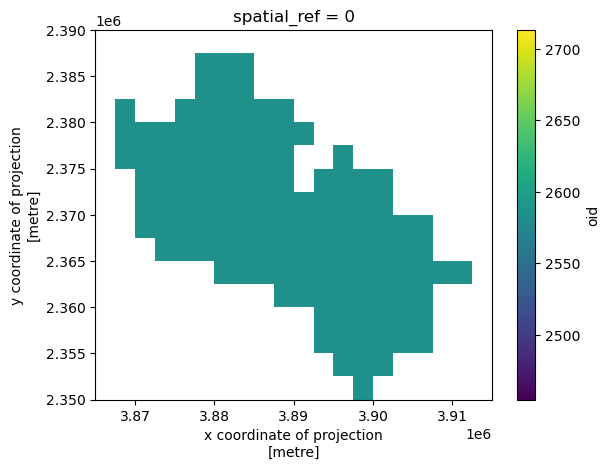

In [12]:
# build a geocube for that catchment with the correct grid resolution
resolution = (-500, 500) if variable == 'pr' else (-2500, 2500)
print(f'Using resolution {resolution}')

cube = make_geocube(
    vector_data=catchment,
    measurements=['oid'],
    resolution=resolution
)

# plot a preview
cube.oid.plot()

# save the parquet file
cube.to_dataframe().reset_index()[['x', 'y', 'oid']].dropna().to_parquet(f'{catchment_id}.parquet')

In [13]:
# generate the Bounding box
xmin = int(cube.x.min().values)
xmax = int(cube.x.max().values)
ymin = int(cube.y.min().values)
ymax = int(cube.y.max().values)

print(f"BBOX ({xmin}, {xmax}, {ymin}, {ymax})")

BBOX (3866250, 3913750, 2351250, 2388750)


## duckdb clip

In [14]:
# prepare the query
SQL = f"""
insert into {variable}
with tmp as (
    select 
        time, 
        (x - {resolution[1]}, y - {resolution[1]}, x + {resolution[1]}, y + {resolution[1]})::box_2d as cell, 
        {variable}
    from '{variable}.parquet'
)
select * from tmp where exists (select 1 from catchment where st_within(point, cell));
"""

print(SQL)


insert into hurs
with tmp as (
    select 
        time, 
        (x - 2500, y - 2500, x + 2500, y + 2500)::box_2d as cell, 
        hurs
    from 'hurs.parquet'
)
select * from tmp where exists (select 1 from catchment where st_within(point, cell));



In [15]:
#
# loop through each year
warns = []
for year in tqdm(range(1950, 2024)):
    # download the file needed
    with tempfile.NamedTemporaryFile(suffix='.nc') as nc:
        try:
            download_hyras(variable, year, nc)
            nc.seek(0)
        except Exception as e:
            warns.append(str(e))
            print(str(e))
            continue
    
        # open the file
        da = xr.open_dataset(nc.name)[variable]
        ds = xr.Dataset({variable: da})

        # transform to long-format parquet
        df = ds.to_dataframe().reset_index()[['time', 'x', 'y', variable]].dropna()
        df.where((df.x >= xmin) & (df.x <= xmax) & (df.y >= ymin) & (df.y <= ymax)).dropna().to_parquet(f"{variable}.parquet")

    # next create the duckdb database
    with duckdb.connect(str(local_cache / f'{catchment_id}.db')) as con:
        # install the spatial extension
        con.install_extension('spatial')
        con.load_extension('spatial')
        con.execute('SET threads=8;')

        # load the catchment
        con.execute(f"CREATE TABLE IF NOT EXISTS catchment AS SELECT oid, st_point(x, y) AS point FROM '{catchment_id}.parquet';")

        # do the magic
        con.execute(f"CREATE TABLE IF NOT EXISTS {variable} (time timestamp, cell box_2d, {variable} double);")
        con.execute(SQL)
    
    # for now we break
    # break

print('DONE.')
if len(warns) > 0:
    print(f'Had {len(warns)} warnings:')
    for w in warns:
        print(f' - {w}')

  0%|          | 0/74 [00:00<?, ?it/s]

File hurs_hyras_5_1950_v5-0_de.nc not found. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/humidity/hurs_hyras_5_1950_v5-0_de.nc)


100%|██████████| 74/74 [04:28<00:00,  3.63s/it]

File hurs_hyras_5_2021_v5-0_de.nc not found. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/humidity/hurs_hyras_5_2021_v5-0_de.nc)
File hurs_hyras_5_2022_v5-0_de.nc not found. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/humidity/hurs_hyras_5_2022_v5-0_de.nc)
File hurs_hyras_5_2023_v5-0_de.nc not found. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/humidity/hurs_hyras_5_2023_v5-0_de.nc)
DONE.
Had 4 warnings:
 - File hurs_hyras_5_1950_v5-0_de.nc not found. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/humidity/hurs_hyras_5_1950_v5-0_de.nc)
 - File hurs_hyras_5_2021_v5-0_de.nc not found. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/humidity/hurs_hyras_5_2021_v5-0_de.nc)
 - File hurs_hyras_5_2022_v5-0_de.nc not found. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/dai

            hurs_mean   hurs_min   hurs_max
date                                       
1951-01-01  90.657951  88.019997  93.227997
1951-01-02  90.317463  86.671997  92.959999
1951-01-03  89.736780  87.028000  92.839996
1951-01-04  81.727512  76.828003  86.087997
1951-01-05  80.780487  73.143997  85.468002
...               ...        ...        ...
2020-12-27  81.156780  76.199997  84.952003
2020-12-28  92.280390  90.580002  93.699997
2020-12-29  87.008390  83.431999  90.047997
2020-12-30  89.618146  87.167999  91.772003
2020-12-31  89.937171  86.776001  92.444000

[25568 rows x 3 columns]
          hurs_mean      hurs_min      hurs_max
count  25568.000000  25568.000000  25568.000000
mean      80.404299     75.785501     84.699217
std       10.432053     11.768928     10.215708
min       34.460878     19.068001     40.680000
25%       73.622805     68.238998     78.320000
50%       82.191952     77.556000     86.912003
75%       88.652025     84.903999     93.016998
max       99.54487

<AxesSubplot:xlabel='date'>

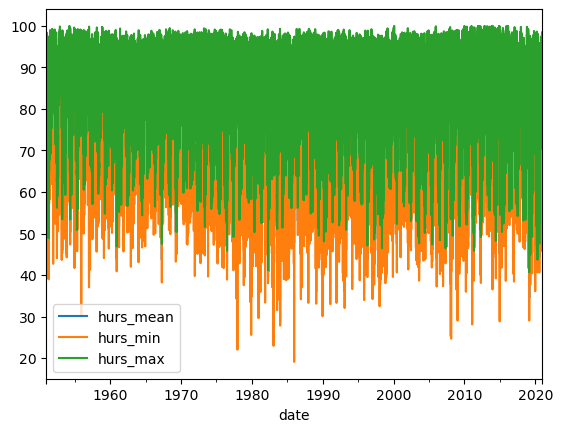

In [16]:
SQL = f"""
select 
    date_trunc('day', time) as date, 
    avg({variable}) as {variable}_mean,
    min({variable}) as {variable}_min,
    max({variable}) as {variable}_max,
from {variable} 
group by date order by date asc;
"""
# Load the data to verify it worked
with duckdb.connect(str(local_cache / f"{catchment_id}.db")) as con:
    df = con.sql(SQL).df().set_index('date')

print(df)
print(df.describe())
df.plot()

## Upload results

**THIS PART IS NOT RUN BY PAPERMILL!**

In case something went wrong and we decide to change notebooks manually, this part can upload the created files to GCE. Note, that changes to the notebook itself cannot be uploaded, which has to be done manually.

In [17]:
# this is the stuff to be uploaded
if not WITH_PAPERMILL:
    from db import DuckProcessor

    proc = DuckProcessor(target_bucket=target_bucket, catchments_path=catchments_path, notebook_bucket=notebook_bucket)

    # save the current state of this notebook
    from IPython.display import display, Javascript
    display(Javascript('IPython.notebook.save_checkpoint();'))

    # Upload the database itself
    database_blob = f"{proc.result_prefix}/{catchment_id}/{catchment_id}_{variable}.db"
    proc.upload(database_blob, f"{catchment_id}.db")

    # upload the catchment as geojson
    catchment_blob = f"{proc.result_prefix}/{catchment_id}/{catchment_id}.geojson"
    proc.target.blob(catchment_blob).upload_from_string(catchment.to_json())

    # upload the notebook
    notebook_blob = f"{proc.result_prefix}/{catchment_id}_clip_catchment_from_hyras.ipynb"
    proc.upload_notebook(notebook_blob, './clip_catchment_from_hyras.ipynb')

<IPython.core.display.Javascript object>

FileNotFoundError: [Errno 2] No such file or directory: 'camels-de-0772adc50345.json'